# NLP Text Analysis Project - Karl Merisalu

<b>Problem:</b> There are many benefits to finding out about important events as early as possible (be it natural disasters, political revolutions or announcements by companies), but the problem is that often times we are late in the game and can hence lose out. 

One of the best places to get early information on events of interest is Twitter. Twitter is hard to follow manually, so in this project we will create a live indicator of Twitter sentiment score, which will help us to determine if there have been any sudden changes be it very positive or negative to our area/keyword of interest. 

### 1) Setting up the environment
We will create a live dashboard based on a loop function and we want the loop function to be efficient (so that it could be quick). In this first step we will set up the environment as much as possible to minimise the tasks to be executed by the loop. 

We start with importing required libraries:

In [1]:
# For data and matrix manipulation
import pandas as pd
import numpy as np

# For visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
import pylab as pl
from IPython import display
import time
import datetime

# For string manipulation
import re 

# For text pre-processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# For assigning sentiment polarity scores
from textblob import TextBlob

# Necessary dependencies from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Karl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Karl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 2) Defining function to clean text
Next we define a function which we will use to clean the messy tweets we're going to pull from Twitter:

In [2]:
# defining a function/method for data cleaning
def clean_text(sample_text):
    
    # Given a sample text (as a string), we first substitute a select few sybmols with white space
    sample_text = re.sub(r'[#|@|-|?|!]',r' ',sample_text)
    
    # We then strip extra white space
    sample_text = re.sub('\s+',' ', sample_text)
    
    # Then change everything to lower case
    sample_text = sample_text.lower()
    
    # Then lemmatize our words -- note,  stemming was deemed too crude here, and therefore not chosen
    sample_text = WordNetLemmatizer().lemmatize(sample_text)
        
    # Now that we transformed our text, we need to tokenize it. Let's treat each word as a token.
    words = word_tokenize(sample_text)
    
    # As we now have a list of words,  we can go ahead and find and remove those words that also belong to the 
    # stopwords list from the NLTK corpus
    words = [w for w in words if w not in stopwords.words('english')]
    
    # We then proceed to joining those list of words, back to 'free text'  or string format
    text = ' '.join(words)
    
    return text

### 3) Using Twitter API
Because we want to build a live dashboard, we need access to live data. This can be arranged with an API. We're going to use Twitter's Standard Developer API, which is somewhat restricted (allows to pull 100 tweets at a time, 1h delay in tweets and a restricted number of pull requests allowed per 15min), but is suitable for this purpose to showcase the live chart.

In order to use Twitter API we need to register an account on their developer site and get credentials that we use to verify our API get requests. If you're new to this, one good place to start is here: https://stackabuse.com/accessing-the-twitter-api-with-python/

As per the instructions above, we have chosen to use Twython python library to use Twitter API. Below we import the library and open Twitter credentials from the json file we created earlier.

In [3]:
# Import the Twython class
from twython import Twython
import json

# Load credentials from json file - these credentials in twitter_credentials.json were saved previously to hide them from 
# showing in public 
with open("twitter_credentials.json", "r") as file:
    creds = json.load(file)

# Instantiate an object
python_tweets = Twython(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])

<b>Next,  we need to define what keywords ('q')</b> we're looking to monitor in Twitter. In this case we will look to pull tweets referencing: 'bitcoin'. Unfortunately, Twitter allows us to pull only 100 tweets at the time, so we will go for the maximum of 100. We will request the most recent 100 tweets referencing 'bitcoin'.

In [4]:
# Create our query
query = {'q': 'bitcoin', # insert search term here
        'count': 100, # pulling the maximum of 100 tweet
        'result_type': 'recent', # pulling most recent tweets (also possible to pull by popularity, etc.)
        'lang': 'en', # pulling tweets in english language
        }

# Creating an empty dataframe where we will be saving (appending) results that will be dispalyed on the live chart
dfrolling = pd.DataFrame() 

### 4) Building the live chart
<b>1)</b> First we use Twython API method to pull tweets as already explained above (and here: https://stackabuse.com/accessing-the-twitter-api-with-python/) 

<b>2)</b> In order to make it "live" to continuously update the status with most recent sentiment, I will build a loop around the API request. 

<b>3)</b> Inside the loop, once I have tweets: I clean the text, then process for sentiment value and finally plot on a chart

Because (almost) everything below will be in a loop and needs to work continuously, it will all need to be in one jupyter notebook cell. Hence, further explanations are provided in the code

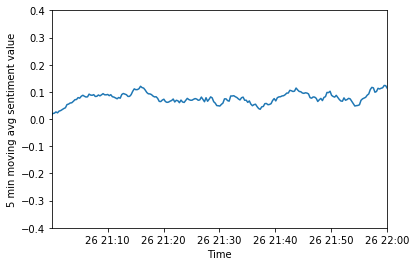

<Figure size 432x288 with 0 Axes>

In [5]:
# 1st search for tweets (as per Twython guidelines)
dict_ = {'user': [], 'date': [], 'text': [], 'favorite_count': []}
for status in python_tweets.search(**query)['statuses']:
    dict_['user'].append(status['user']['screen_name'])
    dict_['date'].append(status['created_at'])
    dict_['text'].append(status['text'])
    dict_['favorite_count'].append(status['favorite_count'])

# Structuring data in a pandas DataFrame for easier manipulation - the purpose of this is to create a dataframe 
# that I can start "appending" with the loop below.
df = pd.DataFrame(dict_)

# Start of the loop: insert range value to how many times we want to run the loop (240)
for i in range(240): 
    dict_ = {'user': [], 'date': [], 'text': [], 'favorite_count': []}
    for status in python_tweets.search(**query)['statuses']:
        dict_['user'].append(status['user']['screen_name'])
        dict_['date'].append(status['created_at'])
        dict_['text'].append(status['text'])
        dict_['favorite_count'].append(status['favorite_count'])

    # Structuring data in a pandas DataFrame for easier manipulation as above (now just in the loop). Saving newly 
    # pulled tweets into 'df2'
    df2 = pd.DataFrame(dict_) 
    
    # Adding df2 results to the dataframe 'df' which we created before the loop note that 'df2' will be overwritten 
    # with new tweets with every loop, but 'df' will contain all tweets/ act as a database
    df = pd.concat([df,df2], ignore_index=True) 
    df.sort_values(by='text', inplace=True, ascending=False)
    
    # The algorithm will pull 100 most recent tweets, but if we don't have 100 new tweets in every cycle then 
    # duplicates will occur to fill the void, so will need to remove duplicates
    df.drop_duplicates(subset = 'text', inplace = True)  
    
    # In order not to modify the master database 'df' we add only necessary information (time and tweet text columns) 
    # from 'df' into a new dataframe 'tweets'
    tweets = df[['text','date']] 
    
    # Formatting tweets 'date' column into datetime and setting 'date' column as index for time series chart later on
    # '%a %b %d %H:%M:%S +0000 %Y' <-- encoding Twitter time into Python datetime understandable date format
    tweets['date'] = pd.to_datetime(tweets['date'], format = '%a %b %d %H:%M:%S +0000 %Y') 
    tweets.set_index('date', inplace = True)
    
    # Sorting tweets by time
    tweets = tweets.sort_index(ascending=0)
    
    # Speficication: I want to display on the chart: most recent 5min moving average sentiment value of tweets with 
    # our keyword. I also want the status to refresh every 15 seconds
    
    # Since standard developer (free) twitter API access has a 60min delay built in, we won't be able to get real live tweets. 
    # We will therefore specify that we want to analyse only tweets from now until 65min in the past (1h delay + 5min). If
    # you have access to real live tweets, change it to 5min instead of 1h + 5min
    movavg = tweets[datetime.datetime.now():(datetime.datetime.now() - datetime.timedelta(minutes=65))] 
    
    # We will apply the text cleaning function that we defined above to the most recent 5min of tweets
    movavg = movavg['text'].apply(lambda x: clean_text(x))
    
    # Creating a new array where we save sentiment values. it's also important to create this/clear it with
    # every loop because we only want the latest data, and not to add new data to old data.
    sentiments = []
    
    # I use TextBlob (which includes a dictionary with polarity scores for each word among other things) to get
    # sentiment values for each (cleaned) tweet
    for tweet in movavg:
        analysis = TextBlob(tweet)
        sentiments.append(analysis.sentiment.polarity)

    # Converting movavg from time series to a dataframe
    movavg = pd.DataFrame(movavg)
    
    # Adding sentiment values to moving average tweets (movavg)
    movavg['sentiments'] = sentiments
    
    # Creating a new dataframe where we add current time and the mean of latest tweet sentiments. This one will be 
    # displayed on the chart and we want it to update (append) with new data while also maintaining old data 
    dfrolling = dfrolling.append({'Time': datetime.datetime.now(), 'movavg': movavg["sentiments"].mean()}, ignore_index=True)
    
    # Plotting the live chart: I choose the chart to show the most recent 60 minutes of sentiment values. Since I decided to 
    # refresh at 15sec and we run the loop for 240 times, we should be just about to be able to fill the full chart in 1h
    axes = plt.gca()
    axes.set_xlim([(datetime.datetime.now() - datetime.timedelta(minutes=60)),datetime.datetime.now()])
    
    # Setting the sentiment limits (y-axis) between -0.4 and 0.4 to be able to see changes better
    axes.set_ylim([-0.4,0.4])
    
    # Feeding data for plotting and naming x and y labels
    pl.plot(dfrolling['Time'], dfrolling['movavg'])
    pl.xlabel('Time')
    pl.ylabel('5 min moving avg sentiment value')
   
    # clearing the old output so that we see only newest data and only 1 chart.
    display.clear_output(wait=True)
    display.display(pl.gcf())
    pl.gcf().clear()
    
    # Insert here value in seconds (15), how often we want the algorithm pull new data. Useful to give some time to allow 
    # for new tweets to be generated
    time.sleep(15) 
    
    # End of the loop

# Once the loop has run its predefined number of times, we finally save the full database 'df' on a disk
df.to_csv('movavg.csv', encoding='utf-8', index=False)

### 5) Conclusion
Based on the chart above, we can tell that tweets containing keyword: 'bitcoin' have been more positive than negative during the past hour. There are no big swings in the mean sentiment analysis, however, it would be interesting to put it into perspective over a longer time period. Generally speaking the number of tweets on Sunday or weekend is lower than during the working week. See the dips in the chart of number of bitcoin tweets here: https://bitinfocharts.com/comparison/bitcoin-tweets.html#3m 

Due to Twitter restrictions, unfortunately I could only live plot tweets with 1h delay, however, should you have access real live Twitter feed, then this tool could be used for various situations for indicating changes in sentiment - for example helping to spot new wildfires in Amazon as of today.

<b>Further research/improvements:</b>
<br><b>1) Accuarcy:</b> These results are based on TextBlob pre-defined dictionary, which doesn't take into account more complicated sentences/meanings and as such should be taken with some suspicion. To develop the algorithm further it may be interesting to go into deep learning field as outlined here: https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e. 

<b>2) Specifications:</b> Based on the number of tweets and the need of timely information, I would recommend to play around with refreshing frequency (sleep value) and with moving average specifications. For identifying macro trends a larger moving average values (and slower refresh rate) could be useful, for micro trends smaller moving average values and faster refresh values could be handy

<b>3) Further development:</b> 1) it would be interesting for example if the application sent an email alert if the sentiment value breached some designated value, 2) an additional idea for further development would be to make user experience simpler, by having the application ask user input for keyword and then run the chart, 3) we could have several moving averages (5sec, 5min, 1h for example) plotted on 1 live chart, which would help puting sentiment values into perspective.